In [19]:
import pandas as pd
import re

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

import spacy
import spacy.cli

import contractions
import unicodedata
import string

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [20]:
#setting options to be able to see whole text in dataframe columns
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.set_option('max_colwidth',800)

In [21]:
#Loading spacy module
nlp=spacy.load('en_core_web_md')

In [22]:
#Reading AskScience submissions data
parent_askscience=pd.read_csv('../datasets/askscience/submissions.csv')

In [23]:
#Reading AskEngineers submissions data
parent_askengineers=pd.read_csv('../datasets/askengineers/submissions.csv',nrows=5074)

In [24]:
parent_askscience.shape, parent_askengineers.shape

((5074, 102), (5074, 80))

In [25]:
parent_askscience.columns;

In [26]:
#Selecting some features that might be interesting to explore
features=['created_utc','id','author','num_comments','score','selftext','subreddit','title']

In [27]:
#defining dataframes of features of interest
askscience_df=parent_askscience[features].copy()
askengineers_df=parent_askengineers[features].copy()
askscience_df.shape, askengineers_df.shape

((5074, 8), (5074, 8))

In [28]:
#Checking AskScience submission counts
askscience_df['subreddit'].value_counts()

askscience    5074
Name: subreddit, dtype: int64

In [29]:
#Checking AskEngineers submission counts
askengineers_df['subreddit'].value_counts()

AskEngineers    5074
Name: subreddit, dtype: int64

In [366]:
askscience_df.head();

In [367]:
#Checking null entries
askscience_df.isnull().sum()

created_utc     0
id              0
author          0
num_comments    0
score           0
selftext        0
subreddit       0
title           0
dtype: int64

In [368]:
askengineers_df.isnull().sum()

created_utc     0
id              0
author          0
num_comments    0
score           0
selftext        0
subreddit       0
title           0
dtype: int64

In [369]:
#checking data types
askscience_df.dtypes

created_utc      int64
id              object
author          object
num_comments     int64
score            int64
selftext        object
subreddit       object
title           object
dtype: object

In [370]:
askengineers_df.dtypes

created_utc      int64
id              object
author          object
num_comments     int64
score            int64
selftext        object
subreddit       object
title           object
dtype: object

In [30]:
#checking for duplicate posts
askscience_df['id'].duplicated().any(), askengineers_df['id'].duplicated().any()

(False, False)

There are no duplicate posts in the data

In [31]:
#concatenating askscience and askengineers dataframe

ask_df=pd.concat([askscience_df,askengineers_df])

In [32]:
#Encoding subreddit Askscience as 1 and AskEngineers as 0
ask_df['subreddit']=ask_df['subreddit'].map({'askscience':1, 'AskEngineers':0})

In [374]:
ask_df.shape

(10148, 8)

In [33]:
ask_df['subreddit'].value_counts()

1    5074
0    5074
Name: subreddit, dtype: int64

## EDA

### Text length and word count comparison

To begin with we will look at the text length and word count for posts of the two categories in the whole data.

In [34]:
ask_df_orig=ask_df.copy()

In [35]:
#Combining text from Title and Selftext
ask_df['title_st']=ask_df['title']+' '+ ask_df['selftext']

In [36]:
ask_df.columns

Index(['created_utc', 'id', 'author', 'num_comments', 'score', 'selftext',
       'subreddit', 'title', 'title_st'],
      dtype='object')

In [37]:
#creating a column for length of title + text
ask_df['title_st_length']=ask_df['title_st'].map(lambda x: len(x))

In [38]:
#creating a column for word counts of title + text
ask_df['title_st_word_count']=ask_df['title_st'].map(lambda x: len(x.split(" ")))

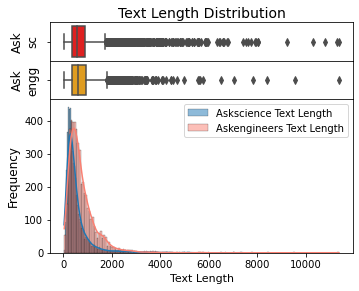

In [43]:
#Text length distibution for the two categories

figure, ax = plt.subplots(3,1, gridspec_kw={'height_ratios':[1,1,4]});
figure.tight_layout();

#Distribution plots

ax[0]=plt.subplot(3,1,3);
ax[0]=sns.histplot(ask_df[ask_df['subreddit']==1]['title_st_length'], 
             label='Askscience Text Length', 
             kde=True,
            alpha=.5);
ax[0]=sns.histplot(ask_df[ask_df['subreddit']==0]['title_st_length'], 
             label='Askengineers Text Length', 
             kde=True,
            color='salmon');
ax[0].set_title('Text Length Distribution', fontsize=14,y=1.4, pad=20);
ax[0].set_ylabel('Frequency', size=12);
ax[0].set_xlabel('Text Length', size=11);
ax[0].legend();

#Boxplots
ax[1]=plt.subplot(3,1,1);
ax[1]=sns.boxplot(x=ask_df[ask_df['subreddit']==1]['title_st_length'],color='red');
ax[1].set_ylabel('Ask\nsc', size=12);
ax[2]=plt.subplot(3,1,2);
ax[2]=sns.boxplot(x=ask_df[ask_df['subreddit']==0]['title_st_length'],color='orange');
ax[2].set_ylabel('Ask\nengg', size=12);


plt.subplots_adjust(hspace=0);
plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.1);
plt.savefig('../images/text_length_distn.png');



It is interesting to note from the above plot that there are much higher counts for longer texts for the posts from 'AskEngineers' subreddit. The boxplots show outliers in terms of the length of posts.  
Engineering posts may need more text in general to descirbe a question compared to Science posts.

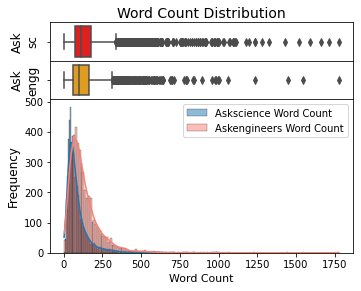

In [44]:
#Word_count distibution for the two categories

figure, ax = plt.subplots(3,1, gridspec_kw={'height_ratios':[1,1,4]})
figure.tight_layout()

#Distribution plots
ax[0]=plt.subplot(3,1,3)
ax[0]=sns.histplot(ask_df[ask_df['subreddit']==1]['title_st_word_count'], 
             label='Askscience Word Count', 
             kde=True,
            alpha=.5)
ax[0]=sns.histplot(ask_df[ask_df['subreddit']==0]['title_st_word_count'], 
             label='Askengineers Word Count', 
             kde=True,
            color='salmon')
ax[0].set_title('Word Count Distribution', fontsize=14,y=1.4, pad=20)
ax[0].set_ylabel('Frequency', size=12)
ax[0].set_xlabel('Word Count', size=11);
ax[0].legend()

#Boxplots
ax[1]=plt.subplot(3,1,1)
ax[1]=sns.boxplot(x=ask_df[ask_df['subreddit']==1]['title_st_word_count'],color='red');
ax[1].set_ylabel('Ask\nsc', size=12)
ax[2]=plt.subplot(3,1,2)
ax[2]=sns.boxplot(x=ask_df[ask_df['subreddit']==0]['title_st_word_count'],color='orange');
ax[2].set_ylabel('Ask\nengg', size=12)

plt.subplots_adjust(hspace=0);
plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.1);
plt.savefig('../images/word_count_distn.png');

The figure above shows word count distribution for the two categories, as expected, similar to length distribution.  

**Total word count comparison for the two subreddits.**    
From the plot it seems like the AskEngineer subreddit has more text.  
Comparing the total word count for each subreddit below.


In [45]:
print(f"Total no. of Words AskScience: {ask_df.groupby('subreddit')['title_st_word_count'].sum()[1]}")
print(f"Total no. of Words AskEngineers: {ask_df.groupby('subreddit')['title_st_word_count'].sum()[0]}")

Total no. of Words AskScience: 444254
Total no. of Words AskEngineers: 662051


As expected total word count for AskEngineers is considerable more compared to AskScience.
We can see that the box plots show some outliers in terms of length of post or number of words but in this case outliers can be considered as just more data. Some submissions/queries may need more text to describe the questions and more text might be helpful to build a strong model. Deciding to keep all the data at this time.

In [46]:
ask_df.shape

(10148, 11)

### No. of authors in each category

In [47]:
#checking unique no. of users in each category
print(f'No of authors in AskScience:')
print(len(ask_df[ask_df['subreddit']==1]['author'].unique()))
print(f'No of authors in AskEngineers:')
len(ask_df[ask_df['subreddit']==0]['author'].unique())

No of authors in AskScience:
4433
No of authors in AskEngineers:


4009

### No. of authors that are common in two categories

In [48]:
#No. of authors that are common in both Ask Science and Ask Engineers subreddits
len([1 for x in ask_df[ask_df['subreddit']==1]['author'] if x in ask_df[ask_df['subreddit']==0]['author']])

0

There are no common authors for the two subreddits.

### Subreddit submission activity

In [49]:
#Askscience statistics
ask_df[ask_df['subreddit']==1].describe()

,created_utc,num_comments,score,subreddit,title_st_length,title_st_word_count
count,5.074000e+03,5074.00000,5074.000000,5074.0,5074.000000,5074.000000
mean,1.532928e+09,45.16555,265.419590,1.0,537.650572,87.554986
std,3.837402e+07,155.04731,1615.987483,0.0,580.864852,82.866803
min,1.503986e+09,0.00000,0.000000,1.0,24.000000,2.000000
25%,1.510444e+09,4.00000,2.000000,1.0,240.000000,42.000000
50%,1.516896e+09,8.00000,5.000000,1.0,367.000000,64.000000
75%,1.523055e+09,15.00000,13.000000,1.0,596.000000,100.000000
max,1.663962e+09,3395.00000,65836.000000,1.0,7380.000000,990.000000


In [50]:
#AskEngineers statistics
ask_df[ask_df['subreddit']==0].describe()

,created_utc,num_comments,score,subreddit,title_st_length,title_st_word_count
count,5.074000e+03,5074.000000,5074.000000,5074.0,5074.000000,5074.000000
mean,1.656521e+09,0.011825,1.000197,0.0,752.196492,130.479109
std,3.861893e+06,0.279848,0.050622,0.0,633.235294,108.898778
min,1.650608e+09,0.000000,0.000000,0.0,33.000000,3.000000
25%,1.653194e+09,0.000000,1.000000,0.0,367.000000,63.000000
50%,1.655931e+09,0.000000,1.000000,0.0,589.000000,102.000000
75%,1.659683e+09,0.000000,1.000000,0.0,944.750000,164.000000
max,1.664346e+09,14.000000,3.000000,0.0,11360.000000,1777.000000


Some of the interesting observations from above statistical information are:  
**1.** The range of created UTC (max-min) for same no. of posts is small for AskEngineers subreddit compared to AskScience, indicating **more posts with selftext per hour for ASkEngineers compared to AskScience**. (This could also mean authors in AskScience dont like to write much self text in their submissions.)

In [51]:
print(f"AskEngineers created UTC min:{ask_df[ask_df['subreddit']==0]['created_utc'].min()}")
print(f"AskEngineers created UTC max: {ask_df[ask_df['subreddit']==0]['created_utc'].max()}")

print(f"AskScience created UTC min:{ask_df[ask_df['subreddit']==1]['created_utc'].min()}")
print(f"AskScience created UTC max: {ask_df[ask_df['subreddit']==1]['created_utc'].max()}")

AskEngineers created UTC min:1650608262
AskEngineers created UTC max: 1664345968
AskScience created UTC min:1503986316
AskScience created UTC max: 1663962461


Converting Epoch time range to hours, it appears that there is 1 post/hour with Selftext for AskEngineers whereas 1 post every 10hours for Ask Science.

**2. Average word count per post** (including title and Selftext) is **88** for a submission in AskScience whereas it is **131** for AskEngineers.

**3. Compairsion of number of comments for the two subreddits**  
From the describe statistics above, it seems that average number of comments are much higher for AskScience (average-45, count ranging from 0 to 3395) posts compared to AskEngineers (average-0.01, count ranging from 0 to only 14).  
Askscience-lower quartile=4, higher quartile=15, whereas AskEngineers has negligble no. of comments.  
Plots below show a distribution for number of comments for the two subreddits.

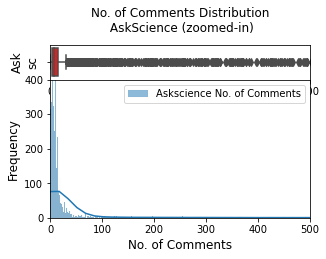

In [52]:
#Distibution of no. of comments for AskScience

figure, ax = plt.subplots(2,1, gridspec_kw={'height_ratios':[1,4]})
figure.tight_layout()

#Distribution plots
ax[0]=plt.subplot(2,1,2)
ax[0]=sns.histplot(ask_df[ask_df['subreddit']==1]['num_comments'], 
             label='Askscience No. of Comments', 
             kde=True,
            alpha=.5)

ax[0].set_title("No. of Comments Distribution\n AskScience (zoomed-in)", fontsize=12,y=1.2, pad=20)
ax[0].set_ylabel('Frequency', size=12)
ax[0].set_xlabel('No. of Comments', size=12);
ax[0].legend()
plt.ylim(0,400)
plt.xlim(0,500)

#Boxplots
ax[1]=plt.subplot(2,1,1)
ax[1]=sns.boxplot(x=ask_df[ask_df['subreddit']==1]['num_comments'],color='red');
ax[1].set_ylabel('Ask\nsc', size=12);
plt.xlim(0,500)

plt.subplots_adjust(hspace=0);
plt.subplots_adjust(left=0.1, right=0.7, top=0.8, bottom=0.2);
plt.savefig('../images/no_comments_sc_distn.png');


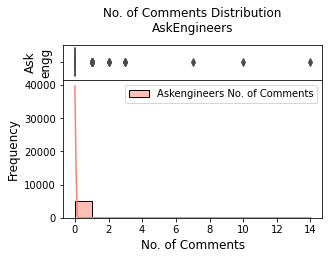

In [53]:
#Distibution of no. of comments for the two categories

figure, ax = plt.subplots(2,1, gridspec_kw={'height_ratios':[1,4]})
figure.tight_layout()

#Distribution plots
ax[0]=plt.subplot(2,1,2)
ax[0]=sns.histplot(ask_df[ask_df['subreddit']==0]['num_comments'], 
             label='Askengineers No. of Comments', 
             kde=True,
            color='salmon')
ax[0].set_title('No. of Comments Distribution\nAskEngineers', fontsize=12,y=1.2, pad=20)
ax[0].set_ylabel('Frequency', size=12)
ax[0].set_xlabel('No. of Comments', size=12);
ax[0].legend()

#Boxplots
ax[1]=plt.subplot(2,1,1)
ax[1]=sns.boxplot(x=ask_df[ask_df['subreddit']==0]['num_comments'],color='orange');
ax[1].set_ylabel('Ask\nengg', size=12)


plt.subplots_adjust(hspace=0);
plt.subplots_adjust(left=0.1, right=0.7, top=0.8, bottom=0.2);
plt.savefig('../images/no_comments_engg_distn.png');

**Looking at the text**

In [54]:
ask_df.head(1)

,created_utc,id,author,num_comments,score,selftext,subreddit,title,title_st,title_st_length,title_st_word_count
0,1663962461,xm7a6n,bmarcus128,0,1,"My typical body temperature hovers around 97.8 F. I'm recovering from COVID, and my temperature is currently about 98.8 F. Do I have a fever? (In other words, is a fever an elevated temperature compared to an individual's baseline or is it a temperature above a certain number?)",1,Does 98.6 Count as a Fever if Your Average Body Temp Trends Low?,"Does 98.6 Count as a Fever if Your Average Body Temp Trends Low? My typical body temperature hovers around 97.8 F. I'm recovering from COVID, and my temperature is currently about 98.8 F. Do I have a fever? (In other words, is a fever an elevated temperature compared to an individual's baseline or is it a temperature above a certain number?)",343,61


Looking at the words for one of the submission

In [55]:
doc=str(ask_df.loc[0,'title_st'])

In [56]:
#Help from lesson 5.04
tokens=word_tokenize(doc.lower())
tokens

['0',
 'does',
 '98.6',
 'count',
 'as',
 'a',
 'fever',
 'if',
 'your',
 'average',
 'body',
 'temp',
 'trends',
 'low',
 '?',
 'my',
 'typical',
 'body',
 'temperature',
 'hovers',
 'around',
 '97.8',
 'f.',
 'i',
 "'m",
 'recovering',
 'from',
 'covid',
 ',',
 'and',
 'my',
 'temperature',
 'is',
 'currently',
 'about',
 '98.8',
 'f.',
 'do',
 'i',
 'have',
 'a',
 'fever',
 '?',
 '(',
 'in',
 'other',
 'words',
 ',',
 'is',
 'a',
 'fever',
 'an',
 'elevated',
 'temperature',
 'compared',
 'to',
 'an',
 'individual',
 "'s",
 'baseline',
 'or',
 'is',
 'it',
 'a',
 'temperature',
 'above',
 'a',
 'certain',
 'number',
 '?',
 ')',
 '0',
 'what',
 'long-term',
 'consequences',
 'will',
 'the',
 'damage',
 'to',
 'nord',
 'stream',
 '1',
 '&',
 'amp',
 ';',
 '2',
 'cause',
 '?',
 'we',
 'all',
 'heard',
 'about',
 'the',
 'damage',
 'to',
 'the',
 'pipelines',
 'and',
 'the',
 'public',
 'discussion',
 'revolves',
 'mainly',
 'around',
 'the',
 'question',
 'of',
 'possible',
 'sabotage'

Looking at the text of several posts, there are noticable occurances of URLs, string patterns, new line, special characters etc. The data will be cleaned to remove these. Also, float numbers, equations and dimensions are present in AskScience and AskEngineers submissions. In order to keep this information, these patterns are defined as 'floatnum','euqation' and 'dimension' etc. during the cleaning process (see the function in following section).

In [57]:
lemmatizer =WordNetLemmatizer()
tokens_lem = [lemmatizer.lemmatize(i) for i in tokens]
tokens_lem

['0',
 'doe',
 '98.6',
 'count',
 'a',
 'a',
 'fever',
 'if',
 'your',
 'average',
 'body',
 'temp',
 'trend',
 'low',
 '?',
 'my',
 'typical',
 'body',
 'temperature',
 'hovers',
 'around',
 '97.8',
 'f.',
 'i',
 "'m",
 'recovering',
 'from',
 'covid',
 ',',
 'and',
 'my',
 'temperature',
 'is',
 'currently',
 'about',
 '98.8',
 'f.',
 'do',
 'i',
 'have',
 'a',
 'fever',
 '?',
 '(',
 'in',
 'other',
 'word',
 ',',
 'is',
 'a',
 'fever',
 'an',
 'elevated',
 'temperature',
 'compared',
 'to',
 'an',
 'individual',
 "'s",
 'baseline',
 'or',
 'is',
 'it',
 'a',
 'temperature',
 'above',
 'a',
 'certain',
 'number',
 '?',
 ')',
 '0',
 'what',
 'long-term',
 'consequence',
 'will',
 'the',
 'damage',
 'to',
 'nord',
 'stream',
 '1',
 '&',
 'amp',
 ';',
 '2',
 'cause',
 '?',
 'we',
 'all',
 'heard',
 'about',
 'the',
 'damage',
 'to',
 'the',
 'pipeline',
 'and',
 'the',
 'public',
 'discussion',
 'revolves',
 'mainly',
 'around',
 'the',
 'question',
 'of',
 'possible',
 'sabotage',
 '.'

In [58]:
p_stemmer =PorterStemmer()
tokens_stem = [p_stemmer.stem(i) for i in tokens]
tokens_stem

['0',
 'doe',
 '98.6',
 'count',
 'as',
 'a',
 'fever',
 'if',
 'your',
 'averag',
 'bodi',
 'temp',
 'trend',
 'low',
 '?',
 'my',
 'typic',
 'bodi',
 'temperatur',
 'hover',
 'around',
 '97.8',
 'f.',
 'i',
 "'m",
 'recov',
 'from',
 'covid',
 ',',
 'and',
 'my',
 'temperatur',
 'is',
 'current',
 'about',
 '98.8',
 'f.',
 'do',
 'i',
 'have',
 'a',
 'fever',
 '?',
 '(',
 'in',
 'other',
 'word',
 ',',
 'is',
 'a',
 'fever',
 'an',
 'elev',
 'temperatur',
 'compar',
 'to',
 'an',
 'individu',
 "'s",
 'baselin',
 'or',
 'is',
 'it',
 'a',
 'temperatur',
 'abov',
 'a',
 'certain',
 'number',
 '?',
 ')',
 '0',
 'what',
 'long-term',
 'consequ',
 'will',
 'the',
 'damag',
 'to',
 'nord',
 'stream',
 '1',
 '&',
 'amp',
 ';',
 '2',
 'caus',
 '?',
 'we',
 'all',
 'heard',
 'about',
 'the',
 'damag',
 'to',
 'the',
 'pipelin',
 'and',
 'the',
 'public',
 'discuss',
 'revolv',
 'mainli',
 'around',
 'the',
 'question',
 'of',
 'possibl',
 'sabotag',
 '.',
 'what',
 'ha',
 "n't",
 'been',
 'di

Stemming finds the root of the word and might take the meaning out of the text so choosing to go with lemmatization after the text cleaning.  
Stop word removal will also be done (we can see stop words in the text which may not contribute in classification of the text).   

### Text Cleaning and preprocessing

Defining the data cleaning, lemmetization and stop word removal functions below.

In [59]:
#Help from https://medium.com/mlearning-ai/nlp-a-comprehensive-guide-to-text-cleaning-and-preprocessing-63f364febfc5


def text_cleaning(df):
    #remove url and other frequent patterns
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'(https?:\S*)|(www\.\S*)','', x))
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'&amp;#x200B;','', x))
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'E&amp;M','', x))
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'R&amp;D','', x))
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'1&amp;2','', x))
    
    #lower case
    df['title_st']=df['title_st'].map(lambda x: x.lower())
    
    #expanding contractions
    df['title_st']=df['title_st'].map(lambda x: ' '.join([contractions.fix(word) for word in x.split()]))
    
    #standardizing accent characters
    df['title_st']=df['title_st'].map(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore'))
        
    # remove new line, lab, carriage return
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'(\\n)|(\\t)|(\\r)','', x))
    
    # remove_mentions_and_tags
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'@\S*','', x))
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'#\S*','', x))
   
    #removing text related to images
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'ImgBBibb','', x))
    
     
    #defining positive and negative numbers
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'(\+\s?\d)',' positivenum ', x))
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'(\-\s?\d)',' negativenum ', x))

    #defining euqation
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'\S+=\S+',' equation ', x))
    
    #defining float numbers
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'\d\.\d',' floatnum ', x))
    
    #defining dimensions
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'[\d]+\s*[xX]\s*[\d]+\s*[xX]\s*[\d]+',' dimension ', x))
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'[\d]+\s*[xX]\s*[\d]+',' dimension ', x))
    
   # defining percentage
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'[\d]+\s*\%',' percentage ', x))
    
    #removing digits
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'[^a-zA-z.,!?/:;\"\'\s]','', x))
    
     # remove special characters: #, [, ], (, ), \,_,/,*,$,@
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'(#)|(\[)|(\])|(\()|(\))|(\\)|(_)|(\/)|(\*)|(\$)|(@)','', x))
    
    #remove punctuatons
    df['title_st']=df['title_st'].map(lambda x: ''.join([char for char in x if char not in string.punctuation]))
    
    return (df)

In [60]:
def lemmatize(df):
    df['title_st_lemma']=df['title_st'].map(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))
    return df

In [61]:
def remove_stop_words(df):
    df['title_st_lemma']=df['title_st_lemma'].map(lambda x: ' '.join([token.text for token in nlp(x) if token.is_stop==False ]))
    return df

### EDA on most frequent words

In [62]:
ask_df.columns, ask_df.shape

(Index(['created_utc', 'id', 'author', 'num_comments', 'score', 'selftext',
        'subreddit', 'title', 'title_st', 'title_st_length',
        'title_st_word_count'],
       dtype='object'),
 (10148, 11))

In [63]:
#Cleaning, lemmatizing and removing the stop words from (title + selftext) text
ask_df_clean=text_cleaning(ask_df)

ask_df_clean=lemmatize(ask_df_clean)

ask_df_clean=remove_stop_words(ask_df_clean)

In [64]:
#Getting the column with clean and processed text
text=ask_df_clean['title_st_lemma']

In [65]:
ask_df_clean.head(1);

In [66]:
#Vectorizing the text
cvec=CountVectorizer()
text_cvec=cvec.fit_transform(text)


In [67]:
text_cvec.shape

(10148, 28256)

There are about **28256** unique words in the whole dataset after cvec transformation.

In [68]:
#using cvec to look at the most frequent words

#Creating dataframe with words as columns 
text_df=pd.DataFrame(text_cvec.todense(),columns=cvec.get_feature_names_out())

In [69]:
text_df['subreddit']=ask_df['subreddit'].values

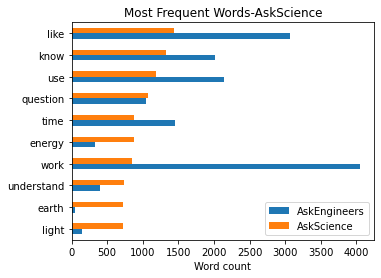

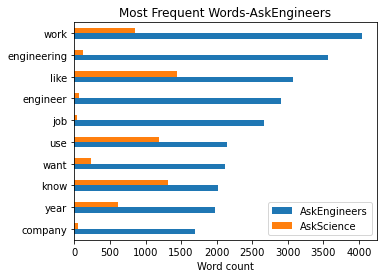

In [73]:
#Most frequent words in subreddit AskScience
text_df.groupby('subreddit').sum().T.sort_values(1,ascending=True).tail(10).plot(kind='barh')
plt.title('Most Frequent Words-AskScience')
plt.xlabel('Word count')
plt.subplots_adjust(left=0.2);
plt.savefig('../images/freq_words_sc.png');
plt.legend(labels=['AskEngineers','AskScience'])
plt.show()

#Most frequent words in subreddit AskEngineers
text_df.groupby('subreddit').sum().T.sort_values(0,ascending=True).tail(10).plot(kind='barh')
plt.title('Most Frequent Words-AskEngineers')
plt.xlabel('Word count')
plt.subplots_adjust(left=0.2);
plt.savefig('../images/freq_words_engg.png');
plt.legend(labels=['AskEngineers','AskScience'])
plt.show()

The plots above show most frequent words for subreddits AskScience and AskEngineers. AskScience has words like earth, light, energy as most frequent whereas Engineering has engineering, engineer, work, job, company etc. Both subreddits aslo have common words like 'like', use, know etc. (Probably would be a good idea to remove engineering related words if the models are too overfit, and words like 'like'.)

It is to be noted that overall the total word count for most frequent words is much higher in AskEngineers indicating that there is much  more text data for subreddit AskEngineers than AskScience. 


### Unique words in each subreddit

In [82]:
#Counting words in each subreddit

text_df_words=text_df.groupby('subreddit').sum().T
text_df_words.reset_index(inplace=True)
text_df_words.columns=['Word','Engg count','Sc count']
text_df_words.sample(3, random_state=42)


,Word,Engg count,Sc count
7499,electricity,89,109
4168,clickbait,0,1
23823,streetcar,0,1


In [83]:
#getting the counts for value=0 in Engg count column (head(1) gives the total count of 0s in the column) giving the number of words that only exist in ASkScience
sc_unique_wordc=text_df_words['Engg count'].value_counts().head(1)
print(f"Unique word count AskScience: {sc_unique_wordc}")

#getting the counts for value=0 in Sc count column- giving the number of words that only exist in ASkEngineers
engg_unique_wordc=text_df_words['Sc count'].value_counts().head(1)
print(f"Unique word count AskEngineers: {engg_unique_wordc}")


Unique word count AskScience: 0    10998
Name: Engg count, dtype: int64
Unique word count AskEngineers: 0    9842
Name: Sc count, dtype: int64


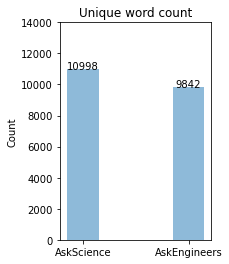

In [84]:
plt.figure(figsize=(3,4))
plt.bar(['AskScience','AskEngineers'],[10998,9842],
       width=0.3,alpha=0.5)
plt.text('AskScience',10998,10998,ha='center')
plt.text('AskEngineers',9842,9842,ha='center')
plt.ylim(0,14000)
plt.title('Unique word count');
plt.ylabel('Count')
plt.subplots_adjust(left=0.2);
plt.savefig('../images/unique_word_count.png');
plt.show()

Plot above shows count of unique words in each subreddit. It is to be noted that out of about 28,256 total words, 10,998 are unique to AskScience and 9842 are unique to AskEngineers, and about 7416 are common.  
It is also to be noted that there was much more text (title and self-text) from AskEngineering compared to AskScience but we have more unique words for AskScience than AskEngineers. This maybe because Science in general contains different fields that include Biology, Physics, Chemistry, Astronomy and Earth Science etc. Engineering is more applied mathematics and science.

In [85]:
#Getting the top 20 unique words in the two subreddits
unique_words=pd.DataFrame()
unique_words['AskScience']=text_df_words[text_df_words['Engg count']==0].sort_values('Sc count', ascending=False).Word.copy()
unique_words.reset_index(inplace=True, drop=True)
unique_words['AskEngineers']=text_df_words[text_df_words['Sc count']==0].sort_values('Engg count', ascending=False).reset_index().Word.copy()
unique_words.head(20)

,AskScience,AskEngineers
0,ama,internship
1,immune,ee
2,dna,cad
3,gravitational,recruiter
4,proton,solidwork
5,username,automotive
6,protein,mechatronic
7,flu,eng
8,nucleus,inperson
9,infection,clearance


The above table lists most frequent 20 unique words in the two subreddits. The words in AskScience are more medicine/biology related like vaccine, virus etc, whereas AskEngineers has wrds like civil,ee,units-mm etc.

From the exploratory data anlaysis, it seems like we have enough text from both the subreddits and enough unique words that we should be able to build a model to classify the two subreddits

### Pre-processing train and test data


**Splitting into train and test**

In [86]:
X=ask_df_orig.drop(columns=['subreddit'])
y=ask_df['subreddit']

In [87]:
#Train test split
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42, stratify=y)

ask_df_orig.head(1)

,created_utc,id,author,num_comments,score,selftext,subreddit,title
0,1663962461,xm7a6n,bmarcus128,0,1,"My typical body temperature hovers around 97.8 F. I'm recovering from COVID, and my temperature is currently about 98.8 F. Do I have a fever? (In other words, is a fever an elevated temperature compared to an individual's baseline or is it a temperature above a certain number?)",1,Does 98.6 Count as a Fever if Your Average Body Temp Trends Low?


In [88]:

X_train.shape,y_train.shape,X_test.shape,y_test.shape

((7611, 7), (7611,), (2537, 7), (2537,))

**Pre-processing and saving**

In [89]:
#combining text from title and selftext
#help from https://stackoverflow.com/questions/61295381/create-new-dataframe-column-from-the-values-of-2-other-columns

X_train['title_st']=X_train['title']+' '+ X_train['selftext']
X_test['title_st']=X_test['title']+' '+ X_test['selftext']

In [330]:
#Cleaning, lemmatizing and removing stop words from X_train (title +selftext) text
X_train_clean=text_cleaning(X_train)

X_train_clean=lemmatize(X_train_clean)

X_train_clean=remove_stop_words(X_train_clean)

In [331]:
#Cleaning, lemmatizing and removing stop words from X_test (title +selftext) text
X_test_clean=text_cleaning(X_test)

X_test_clean=lemmatize(X_test_clean)

X_test_clean=remove_stop_words(X_test_clean)

In [332]:
#Saving clean train and clean test data
train_clean=X_train_clean
train_clean['subreddit']=pd.DataFrame(y_train)
train_clean.to_csv('../datasets/train_clean.csv',index=False)

test_clean=X_test_clean
test_clean['subreddit']=pd.DataFrame(y_test)
test_clean.to_csv('../datasets/test_clean.csv',index=False)
